In [28]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

# Algorithms
from sklearn.svm import SVC

# Internal
from autocat.data.datasets import get_training_data
from autocat.data.features import CombinedFeatureAdder, feature_transactions_per_day, PandasDataFrameTransformer
from autocat.data.filters import FeatureFilters, no_null_StdUnitsShipped_StdNetAmount
from autocat.models import GridSearchModel, Model
from autocat.models.evaluation import evaluate, plot_learning_curve, get_scorer
from autocat.models.pipelines import get_scaled_pipeline_v1

## Pipeline

In [33]:
TRAINING_DATA = '../data/processed/train_2018-08-24.csv'

# Create feaure matrix and label vector
X, y = get_training_data(TRAINING_DATA, [
    no_null_StdUnitsShipped_StdNetAmount
], drop_na=True)

In [35]:
# Get the scaled pipeline
pipeline = get_scaled_pipeline_v1(X)
print(pipeline)

Pipeline(memory=None,
     steps=[('feaure_transactions_per_day', CombinedFeatureAdder(attribute_fn=<function feature_transactions_per_day at 0x1139637b8>)), ('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('data_frame', PandasDataFrameTransformer(columns=['AvgUnitsShipped', 'StdUnitsShipped', 'MinUnitsShipped', 'MaxUnitsShipped', 'AvgNetAmount', 'StdNetAmount', 'MinNetAmount', 'MaxNetAmount', 'NumberOfTransactions', 'NumberOfTransactionDays', 'TransactionsPerDay']))])


In [37]:
print('Training instances:', len(X))

Training instances: 5610


## Model

In [38]:
# Create the parameter grid
param_grid = [
    {
        'svm__gamma': [0.001, 0.01, 0.05, 0.1, 1, 10, 100], 
        'svm__C': [.01, .1, 1., 10, 50, 100, 110, 125],
    }
]

In [39]:
# Train a model using grid search
# scorer = make_scorer(f1_score, average='micro')
# svm_model = GridSearchModel(param_grid, name='svm', model=SVC(), pipeline=pipeline)
# svm_model.train(X, y, 10, scorer)

In [41]:
# Create existing model
model_base = SVC(C=125, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
model = Model('svm', model_base, pipeline).fit(X, y)
print('Existing model spec:\n', model.model)

Existing model spec:
 SVC(C=125, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [42]:
# Last model:
    
# SVC(C=125, cache_size=200, class_weight=None, coef0=0.0,
#   decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
#   max_iter=-1, probability=False, random_state=None, shrinking=True,
#   tol=0.001, verbose=False)

## Evaluation

In [43]:
X_transformed = model.pipeline.fit_transform(X)
model_predictions = model.model.predict(X_transformed)

#### Training Set

In [55]:
scorer = get_scorer()
results = model.score(X, y, scorer)
print('Score:', results[0])
print(classification_report(y, results[1]))

Score: 0.7395721925133689
                      precision    recall  f1-score   support

           Body Care       0.75      0.79      0.77       936
              Frozen       0.95      0.06      0.11       308
                Meat       1.00      0.74      0.85       102
    Packaged Grocery       0.73      0.96      0.83      3005
        Packaged Tea       1.00      0.05      0.10       222
Refrigerated Grocery       0.78      0.46      0.58       595
            Vitamins       0.70      0.36      0.47       442

         avg / total       0.76      0.74      0.70      5610



#### Cross Validation

In [56]:
CV=10

In [57]:
cv_predictions = cross_val_predict(model.get_model_pipeline(), X, y, cv=CV)
print(f1_score(y, cv_predictions, average='micro'))
print(classification_report(y, cv_predictions))

0.6994652406417112
                      precision    recall  f1-score   support

           Body Care       0.70      0.75      0.73       936
              Frozen       0.12      0.01      0.02       308
                Meat       0.84      0.58      0.69       102
    Packaged Grocery       0.71      0.93      0.80      3005
        Packaged Tea       0.36      0.02      0.03       222
Refrigerated Grocery       0.72      0.40      0.51       595
            Vitamins       0.55      0.26      0.36       442

         avg / total       0.65      0.70      0.65      5610



The SVM model performs well for:
* Body Care
* Meat
* Packaged Grocery


The KNN model performs  slightly better overall but the SVM performs better (w.r.t. precision) on Refigerated Grocery and Packaged Tea.

#### Confusion Matrix

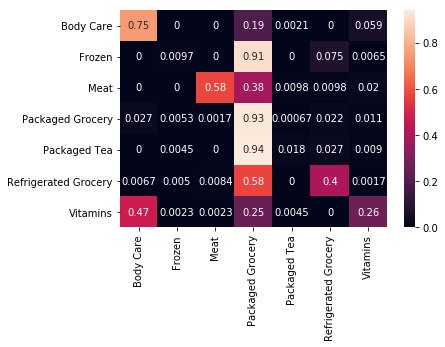

In [60]:
conf_mat = confusion_matrix(y, cv_predictions, labels=np.sort(y.unique()))
conf_mat_df = pd.DataFrame(
    conf_mat, 
    index=np.sort(y.unique()), 
    columns=np.sort(y.unique()))

conf_mat_props = pd.DataFrame(
    conf_mat_df.values / conf_mat_df.sum(axis=1)[:,None],
    index=np.sort(y.unique()), 
    columns=np.sort(y.unique()))

sns.heatmap(conf_mat_props, annot=True);

In [61]:
conf_mat_props.apply(lambda x: (x == 0).sum()).mean()

1.7142857142857142

This confusion matrix has more zero-valued entries per category than the KNN model indicating that the SVM model is doing a better job at reducing false negatives.

#### Learning Curve

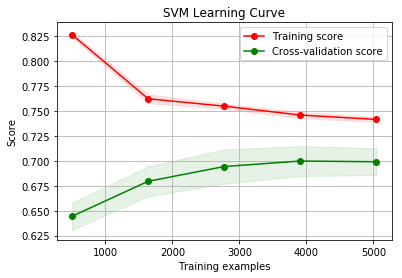

In [63]:
# Plot the learning curve
plot_learning_curve(model.get_model_pipeline(), 'SVM Learning Curve', X, y, cv=CV);

The model appears to be suffering from high variance.

In [67]:
Model.save(model.model, '../models/svm-2018-08-24.model')